##Uploading the data

NOTE: this was code was taken from the Linear Regression homework/lecture.

In [ ]:
!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# link: https://drive.google.com/file/d/183EV-cLxBCacF6MRVrw9i5DBcj9JGWz0/view?usp=sharing
# fileid: 183EV-cLxBCacF6MRVrw9i5DBcj9JGWz0

# 2. Now proxy the Google Drive file to a local file
data_import = drive.CreateFile({'id':'183EV-cLxBCacF6MRVrw9i5DBcj9JGWz0'})
data_import.GetContentFile('combined.csv') # 'cancer_data.csv' is the file name that will be accessible in the notebook.


In [ ]:
# Load the data into a Pandas data frame

import pandas as pd
from sklearn import preprocessing

# Read input
df = pd.read_csv("combined.csv") 

del df['Unnamed: 0']
print(df.head(5))


      Unnamed: 0.1  A1CF  A2M  A2ML1  ...  ZSCAN4.n  ZSWIM7.p  ZSWIM7.n  classLabels
0  TCGA.BL.A0C8.01     0    0      0  ...         1         0         1            1
1  TCGA.BL.A13I.01     0    0      0  ...         0         0         0            1
2  TCGA.BL.A13J.01     0    0      0  ...         0         0         1            1
3  TCGA.BL.A3JM.01     0    1      0  ...         0         1         0            1
4  TCGA.BT.A0S7.01     0    0      0  ...         0         1         0            1

[5 rows x 13152 columns]


In [ ]:
# Preprocessing
# This was also taken from the lecture, but don't think there needs to be any
# preprocessing such that the series is zero based - it only contains 1s and 0s.
encoder = preprocessing.LabelEncoder()

for col in df.columns: # For each column in the data frame
    df[col] = encoder.fit_transform(df[col]) # Transform the series so is zero based

    


## Import statements for models

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, auc
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, RFECV, SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, roc_curve
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
import time


In [ ]:
# Separating the features, discard the sample IDs, separate class labels
features = df.columns[1:-1]
X = df[features]
y = df['classLabels']

featureIndex = dict()
geneKeys = dict() # used to store the mutation types for all genes in the study

for i in range(len(features)):
    featureIndex[i] = features[i]

    if '.n' not in features[i] and '.p' not in features[i]:  # somatic genes
        gene = features[i]
        if gene not in geneKeys.keys():
            geneKeys[gene] = [features[i]]
    
    else:
        if '.n' in features[i]:
            gene = features[i].replace('.n', '')
            if gene not in geneKeys.keys():
                geneKeys[gene] = [features[i]]
            else:
                geneKeys[gene].append(features[i])

        elif '.p' in features[i]:
            gene = features[i].replace('.p', '')
            if gene not in geneKeys.keys():
                geneKeys[gene] = [features[i]]
            else:
                geneKeys[gene].append(features[i])

# Make validation set
# Split the total dataset into validation and training/testing. 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1661, 
                                                  stratify = y)


In [ ]:
def gatherTopGenes(X, y, labels, selectionFn):
    """
    Gets the top most predictive genes by implement SelectKBest and chi2 selection
    function.
    """
    topGenesDict = dict()  # keeps track of the placement of the gen

    # 1. Get the top predictors
    # This is classifying performance as a function of # selected predictors
    # Rank genes in terms of
    print("Gathering top ranked genes") 
    for i in range(50):  # repeat 50 times
        
        start = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, 
                                                            stratify=y)

        bestfeatures = SelectKBest(score_func=selectionFn, k=4500)
        bestfeatures.fit(X_train, y_train)

        bestfeatures_df = pd.DataFrame({'Feature':list(X_train.columns),
                                        'Scores': bestfeatures.scores_})
    

        # Store the features in ranked order
        newdf = bestfeatures_df.sort_values(by='Scores', ascending=False)        

        # We want to keep track of which genes have been encountered in this 
        # iteration so as to not overcount multiple features of a gene
        genesEncountered = set()

        # Store the genes in ranked order
        features = list(newdf['Feature'])

        for j in range(len(features)):
            
            feature = features[j]
            # Get gene name
            gene = feature
            if '.n' in feature:
                gene = gene.replace('.n','')
            elif '.p' in feature:
                gene = gene.replace('.p','')
            
            # First time seeing this gene
            # Add the placement to the genes
            if gene not in genesEncountered:
                if gene not in topGenesDict.keys():
                    topGenesDict[gene] = [j]
                else:
                    topGenesDict[gene].append(j)
                genesEncountered.add(gene)
            

    for gene in topGenesDict.keys():
        topGenesDict[gene] = sum(topGenesDict[gene])
    
    sortedGenes = sorted(topGenesDict.items(), key=lambda item: item[1])
    sortedGenes = {k: v for k, v in sortedGenes}

    return sortedGenes

In [ ]:
def multiNBTop(X, y, labels, selectionFn, topGenesDict):
    """
    MNB function that calculates accuracies across gene sets of increasing size.
    """
    # Save genes that make top 50 each time
    print("Genes gathered.")
    # Get the top 50 and 900 genes
    top50 = list(topGenesDict)[:50]
    top900 = list(topGenesDict)[:900]
    
    # 2. Calculate overall accuracy as fcn of # selected predictors, increasing
    # number of predictors
    
    accuracyDict = dict()  # store the list of accuracies per genes considered
    # keys include the number of genes we're looking at, value is their overall accuracy
    print("Moving onto gathering accuracies...")
    
    for i in range(1): 
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, 
                                                            stratify=y)
        rankedFeatures = []  # stores the features that we're considering in order
        numGenes = 0

        for gene in topGenesDict.keys():  # go through each gene
            numGenes += 1
            if numGenes > 4500:
                break
            else:
                start = time.time()
                if len(rankedFeatures) == 0:  # this is the first iteration 
                    geneFeatures = geneKeys[gene]  # grab the features for this gene
                    rankedFeatures += geneFeatures
                else:  # add onto the features
                    geneFeatures = geneKeys[gene]
                    rankedFeatures += geneFeatures
                # 2a. Train according to the features gathered so far
                #X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, 
                #                                                stratify=y)
                
                print("{} genes, {} features".format(numGenes, len(rankedFeatures)))
                clf = MultinomialNB()

                clf.fit(X_train[rankedFeatures], y_train)

                y_pred = clf.predict(X_test[rankedFeatures])
                score = metrics.accuracy_score(y_test, y_pred)
                accuracyDict[numGenes] = score
                #print(numGenes, score)
                print("Time elapsed: {} seconds".format(time.time() - start))
                print("---")

    sortedAccuracyDict = sorted(accuracyDict.items(), key=lambda item: item[1],
                                reverse=True)
    
    sortedAccuracyDict = dict(sortedAccuracyDict)

    # Plotting the # of genes vs accuracies
    x_axis = sorted(sortedAccuracyDict.keys())
    y_axis = []
    for x in x_axis:
        y_axis.append(sortedAccuracyDict[x]*100)

    fig, ax = plt.subplots()
    ax.plot(x_axis, y_axis)
    ax.set(xlabel='Number of genes Used', ylabel='Overall Accuracy (%)',
           title = 'Percent Accuracy According to Number of Genes Used') 
    
    fig.savefig("plottedAccuracies.png")
    plt.show()   
    return sortedAccuracyDict, top50, top900
    


SyntaxError: ignored

In [ ]:
# Gather the top genes

# Dictionary for translating class label numeric values to respective cancer names
classLabels = {1: 'Bladder urothelial carcinoma', 2: 'Breast invasive carcinoma', 
         3: 'Colorectal adenocarcinoma', 4: 'Glioblastoma', 
         5: 'Head and neck squamous cell carcinoma', 
         6: 'Kidney renal clear cell carcinoma', 
         7: 'Acute myeloid leukaemia', 8: 'Lung adenocarcinoma', 
         9: 'Lung squamous cell carcinoma', 10: 'Ovarian serous cystadenocarcinoma', 
         11: 'Uterine corpus endometrial carcinoma', 12: 'Adenoid cystic carcinoma', 
         13: 'Brain lower grade glioma', 
         14: 'Cervical squamous cell carcinoma and endocervical adenocarcinoma', 
         15: 'Kidney renal papillary cell carcinoma', 16: 'Liver hepatocellular carcinoma', 
         17: 'Pancreatic adenocarcinoma', 18: 'Prostate adenocarcinoma', 
         19: 'Skin cutaneous melanoma', 20: 'Stomach adenocarcinoma', 
         21: 'Papillary thyroid carcinoma', 22: 'Adrenocortical carcinoma', 
         23: 'Kidney chromophobe', 24: 'Pheochromocytoma and paraganglioma', 
         25: 'Sarcoma', 26: 'Testicular germ cell cancer', 
         27: 'Uterine carcinosarcoma', 28: 'Uveal melanoma'
         }
topGenesDict = gatherTopGenes(X_train, y_train, classLabels.values(), chi2)



Gathering top ranked genes


In [ ]:
def plotConfusionMatrix(y_true, y_pred):
    # Create a confusion matrix
    cm = confusion_matrix(y_true, y_predict, normalize='all')

    # Make the figure
    fig = plt.figure(figsize=(6, 6))
    plt.title("Heatmap from Confusion Matrix")
    #ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
    labels = list(y_index_key.keys())

    plt.ylabel("Classes")
    
    plt.xlabel("Classes")
    
    plt.imshow(cm)
    plt.xticks([i for i in range(28)], labels, rotation=90)     
    plt.yticks([i for i in range(28)], labels)  

    # Not actually used for the final assignment, but good to have nonetheless

In [ ]:
# The most time-consuming part, calculating the accuracies across all those gene sets.
start_time = time.time()

# Call to multiNBTop(), will return the accuracies and the number of genes
accuracies, top50, top900 = multiNBTop(X_train, y_train, classLabels.values(), 
                                       chi2, topGenesDict)

print("Elapsed time: ", time.time() - start_time)

In [ ]:
# The highest accuracy is 0.6405622489959839
# Find all of the numbers of genes that yield this accuracy

optimalGenes = []
for geneSet in accuracies:
    if accuracies[geneSet] == 0.6405622489959839:
        optimalGenes.append(geneSet)
numGenes = min(optimalGenes)

expectedBestGenes = ['BRAF', 'IDH1', 'KRAS', 'NPM1', 'NRAS', 'PTEN', 'TP53', 'C3ORF84', 'C8ORF82', 'C18ORF63', 'DUX4', 'PCAT2', 'SELO', 'TTLL8', 'ZNF736', 'CDKN2A', 'ERG', 'ZFPM1', 'OR1D4', 'FBXW7', 'MANSC4', 'LYPD8', 'PIK3CA', 'STMND1', 'APC', 'CDRT7', 'GATA3', 'SLC22A31', 'TRBC2-TRBV2-TRBV9-TRBV19-TRBV27-TRBV28', 'GNAQ', 'TMEM78', 'RBM4', 'ZDHHC11B', 'NKX2-1', 'ANKRD33B', 'MRLN', 'RGPD3', 'SMIM1', 'C11ORF44', 'ARHGEF40', 'SEC62', 'TWIST2', 'KCNIP1', 'GNA11', 'CCDC6', 'ZFHX3', 'C16ORF47', 'IMMP2L', 'TRIM49B', 'UNKL']


In [ ]:
def generalMNB(X, y, labels, features, topGenesDict, xVal, yVal):
    '''
    General MNB classifier, also used in validation testing if xVal and yVal are
    specified.
    '''
    n = 100
    avgAccuracy = []
    avgPrecision = []
    avgRecall = []

    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, 
                                                                stratify=y)

        clf = MultinomialNB()

        
        clf.fit(X_train[features], y_train)

        # Used for training
        y_pred = []

        if xVal is not None and yVal is not None:
            y_pred = clf.predict(xVal[features])
        else:
            y_pred = clf.predict(X_test[features])

        if yVal is not None:
            y_test = yVal
        score = metrics.accuracy_score(y_test, y_pred)
        avgAccuracy.append(score)
        avgPrecision.append(precision_score(y_test, y_pred, #labels=labels,
                                            average=None))
        avgRecall.append(recall_score(y_test, y_pred, #labels=labels,
                                         average = None))
            
    finalAccuracy = sum(avgAccuracy) / n
    finalPrecisions = []
    finalRecalls = []
    for i in range(28):  # for each cancer type
        totalP = 0 
        totalR = 0
        for j in range(n):  # loop through the arrays
            totalP += avgPrecision[j][i]
            totalR += avgRecall[j][i]
        
        finalPrecisions.append(totalP / n)
        finalRecalls.append(totalR / n)
    
    width = 0.4
    fig, ax = plt.subplots()
    fig.set_size_inches(5,10.5)

    labels = ['Bladder urothelial carcinoma', 'Breast invasive carcinoma', 
              'Colorectal adenocarcinoma', 'Glioblastoma', 
              'Head and neck \n squamous cell carcinoma', 
              'Kidney renal clear \n cell carcinoma', 
              'Acute myeloid leukaemia', 'Lung adenocarcinoma', 
              'Lung squamous cell carcinoma', 
              'Ovarian serous cystadenocarcinoma', 
              'Uterine corpus endometrial carcinoma', 
              'Adenoid cystic carcinoma', 
              'Brain lower grade glioma', 
              'Cervical squamous cell carcinoma \n and endocervical adenocarcinoma', 
              'Kidney renal papillary cell carcinoma', 
              'Liver hepatocellular carcinoma', 
              'Pancreatic adenocarcinoma', 
              'Prostate adenocarcinoma', 'Skin cutaneous melanoma', 
              'Stomach adenocarcinoma', 'Papillary thyroid carcinoma', 
              'Adrenocortical carcinoma', 'Kidney chromophobe', 
              'Pheochromocytoma and paraganglioma', 'Sarcoma', 
              'Testicular germ cell cancer', 'Uterine carcinosarcoma', 
              'Uveal melanoma']

    labels.reverse()
    finalPrecisions.reverse()
    finalRecalls.reverse()

    ax.barh(np.arange(28), finalPrecisions, width, label='Precision')
    ax.barh(np.arange(28)+width, finalRecalls, width, label='Recalls')


    plt.legend(loc="upper right")

    ax.set_yticks(np.arange(28)+0.5*width)
    ax.set_ylim([-1,29])
    ax.set_xlim([0, 1])
    ax.set_yticklabels(labels)
    plt.show()

    print("Final Accuracy: ", finalAccuracy)
     

452 769 774


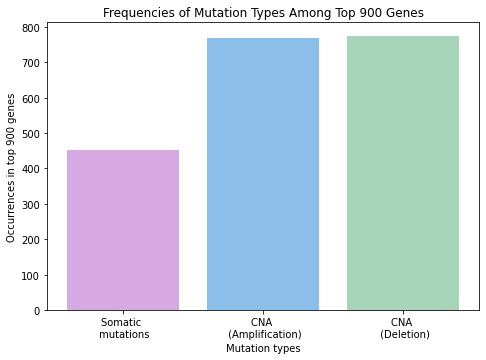

In [ ]:
# Okay, now test with the minimum nmber of genes needed for highest accuracy
# Let's test if it was just a fluke
# In case the RAM runs out, numGenes = 3468
numGenes = 3468

optimalGenes = list(geneKeys.keys())[:numGenes]
optimalFeatures = []

for gene in optimalGenes:
    features = geneKeys[gene]
    optimalFeatures += features

labels = []
for i in range(1, 29):
    labels.append(classLabels[i])

#generalMNB(X_train, y_train, classLabels.values(), features=optimalFeatures, 
#           topGenesDict=topGenesDict, xVal = X_val, yVal = y_val)

myGenes = set(list(topGenesDict.keys())[:900])
expectedGenes = set(['BRAF', 'IDH1', 'KRAS', 'NPM1', 'NRAS', 'PTEN', 'TP53', 'C3ORF84', 'C8ORF82', 'C18ORF63', 'DUX4', 'PCAT2', 'SELO', 'TTLL8', 'ZNF736', 'CDKN2A', 'ERG', 'ZFPM1', 'OR1D4', 'FBXW7', 'MANSC4', 'LYPD8', 'PIK3CA', 'STMND1', 'APC', 'CDRT7', 'GATA3', 'SLC22A31', 'TRBC2-TRBV2-TRBV9-TRBV19-TRBV27-TRBV28', 'GNAQ', 'TMEM78', 'RBM4', 'ZDHHC11B', 'NKX2-1', 'ANKRD33B', 'MRLN', 'RGPD3', 'SMIM1', 'C11ORF44', 'ARHGEF40', 'SEC62', 'TWIST2', 'KCNIP1', 'GNA11', 'CCDC6', 'ZFHX3', 'C16ORF47', 'IMMP2L', 'TRIM49B', 'UNKL'])
#overlap = myGenes.intersection(expectedGenes)

numSM = 0
numCNAp = 0
numCNAn = 0
for gene in myGenes:
    if len(geneKeys[gene]) == 1:
        numSM += 1
    else:
        for mut in geneKeys[gene]:
            if mut == gene:
                numSM += 1
            elif '.p' in mut:
                numCNAp += 1
            elif '.n' in mut:
                numCNAn += 1
print(numSM, numCNAp, numCNAn)

fig = plt.figure

labels = ['Somatic \n mutations', 'CNA \n (Amplification)', 'CNA \n (Deletion)']
values = [numSM, numCNAp, numCNAn]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels, values, color=('#D7A9E3FF', '#8BBEE8FF', '#A8D5BAFF'))
 
# creating the bar plot
#plt.bar([1,4,7],[numSM, numCNAp, numCNAn], width = 2,
#        color=('#D7A9E3FF', '#8BBEE8FF', '#A8D5BAFF'))
 
plt.xlabel("Mutation types")
#plt.xticks(ticks = [1, 8, 15], labels = ['Somatic \n mutations', 'CNA \n (Amplification)', 'CNA \n (Deletion)'])
plt.ylabel("Occurrences in top 900 genes")
plt.title("Frequencies of Mutation Types Among Top 900 Genes")
plt.show()

